In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Funciones

In [2]:
def info_plus(df):
    """
    El objetivo de esta función es el de mostrar algo más de información acerca del estado del dataframe.
    Para ello, la función recibe un dataframe completo y muestra como output otro dataframe que contiene la siguiente información relativa a cada columna:
    -Tipo de dato
    -Número de entradas no nulas
    -Porcentaje de entradas no nulas
    -Número de valores únicos
    -Porcentaje de valores únicos

    Adicionalmente también devuelve el número de registros del dataframe original.
    """

    dtype = []
    non_null = []
    non_null_per = []
    unique = []
    unique_per = []

    for column in df.columns:
        dtype.append(df[column].dtype)
        non_null.append(df[column].notnull().sum())
        non_null_per.append(round(df[column].notnull().mean(), 3))
        unique.append(df[column].nunique())
        unique_per.append(round(df[column].nunique()/df.shape[0], 3))
    
    info = pd.DataFrame({"dtype": dtype,
                         "non_null": non_null, 
                         "unique": unique,
                         "non_null_per": non_null_per,
                         "unique_per": unique_per}, index = df.columns)
    print(info)
    print("length: ", df.shape[0])

    return

    

In [3]:
def date_conv(str_date):
    """
    El objetivo de esta función es el de hallar la fecha más antigua de entre dos opciones no necesariamente parseadas.
    Para ello, la función recibe como input una lista con dos campos de fechas, pudiendo estar procesadas o no.
    Procesa dichas fechas en caso de ser necesario y si no es posible asigna el valor NaT. 
    Si el año supera un umbral se restan 100 años.
    Compara ambas fechas y escoge la más antigua, devolviendo solo el año de esta.
    """
    
    dates = []
    for d in str_date:
        try:
            date = pd.to_datetime(d).date()
            dates.append(date)
        except:
            date = pd.NaT
            dates.append(date)
        
    try:
        if (type(dates[0]) != type(dt.date.today())) and (type(dates[1]) == type(dt.date.today())):
            date_min = dates[1].year
        elif type(dates[1]) != type(dt.date.today()) and (type(dates[0]) == type(dt.date.today())):
            date_min = dates[0].year
        elif (type(dates[0]) == type(dt.date.today())) and (type(dates[1]) == type(dt.date.today())):
            year_0 = dates[0].year
            year_1 = dates[1].year
            if year_0 > 2020:
                year_0 = year_0 - 100
            if year_1 > 2020:
                year_1 = year_1 - 100
            if (year_0 - year_1) > 0:
                date_min = year_1
            else:
                date_min = year_0
        else:
            date_min = pd.NaT
            
    except:
        pass

    return date_min

In [4]:
def get_genres(row):
    """
    El objetivo de esta función es el de procesar el campo de los géneros, que viene dado como una falsa lista.
    Para ello, la función recibe una cadena de caracteres correspondiente a la falsa lista.
    Limpia la cadena y fragmenta los géneros separándolos en una lista real.
    Adicionalmente devuelve el valor "F", si la obra es de Ficción, "NF" en caso de ser No Ficción o "-" en caso de no poder determinarlo.
    """

    genre_list = row[0][1:-1].replace("'", "").split(",")[:10]
    genre_list = [genre.strip().lower() for genre in genre_list]
    
    if "fiction" in genre_list:
        fiction = "F"
    elif "nonfiction" in genre_list:
        fiction = "NF"
    else:
        fiction = "-"
    
    return genre_list, fiction



In [5]:
def get_main(genre_lists):

    """
    El objetivo de esta función es el de obtener un único género que identifique a la obra.
    Para ello, la función recibe la una lista con todas las listas de géneros ya procesada (recibe la columna completa),
    y crea dos diccionarios donde se seleccionan los géneros más comunes de la ficción y no ficción.
    Posteriormente, se recorre cada lista individualmente, y el primer género que se encuentre en la lista correspondiente,
    es catalogado como género principal. En caso de no encontrar ninguno, se cataloga como "Other".
    """
    
    main_column = []
    f_genres_dict = {}
    nf_genres_dict = {}

    for genre_list in genre_lists:
        if "fiction" in genre_list:
            for genre in genre_list:
                if genre == "fiction":
                    pass
                elif genre in f_genres_dict:
                    f_genres_dict[genre] += 1
                else:
                    f_genres_dict[genre] = 1

        elif "nonfiction" in genre_list:
            for genre in genre_list:
                if genre == "nonfiction":
                    pass
                elif genre in nf_genres_dict:
                    nf_genres_dict[genre] += 1
                else:
                    nf_genres_dict[genre] = 1
    
    common_f_genres = pd.DataFrame({"X": pd.Series(f_genres_dict)}).sort_values("X", ascending = False).iloc[:19].index.tolist()
    common_nf_genres = pd.DataFrame({"X": pd.Series(nf_genres_dict)}).sort_values("X", ascending = False).iloc[:19].index.tolist()

    for genre_list in genre_lists:
        if len(genre_list) > 0:
            for genre in genre_list:
                if ("fiction" in genre_list) and (genre in common_f_genres):
                    main = genre.capitalize()
                    break
                elif ("nonfiction" in genre_list) and (genre in common_nf_genres):
                    main = genre.capitalize()
                    break
                elif ("fiction" in genre_list) or ("nonfiction" in genre_list):
                    main = "Other"
                elif (genre in common_f_genres) or (genre in common_nf_genres):
                    main = genre.capitalize()
                    break
                else:
                    main = "Other"
                    
        else:
            main = None
            
        main_column.append(main)

    return main_column

In [6]:
def reassign_fiction(row, f_genres, nf_genres):

    """
    El objetivo de esta función es el de clasificar aquellas obras que no sabemos si son ficción o no ficción.
    Para ello, la función recibe como input la fila completa, así como la lista de géneros más habituales.
    Si el género que define la obra es distinto de "Other" y se encuentra en alguna de las listas, se hace la 
    asignación correspondiente.
    """
    
    if (row["fiction"] == "-") & (row["genre"] != "Other"):
        if row["genre"] in f_genres:
            row["fiction"] = "F"
        elif row["genre"] in nf_genres:
            row["fiction"] = "NF"

    return row["fiction"]

In [7]:
def get_ratings(row):

    """
    El objetivo de esta función es el de limpiar la lista con los porcentajes de las valoraciones de la obra.
    Para ello, la función recibe la lista con el número de valoraciones de cada tipo y las divide entre el número
    de valoraciones totales.
    """

    rating_list = row["ratingsByStars"]
    try:
        s5 = round(int(rating_list[0])/row["numRatings"], 3)
        s4 = round(int(rating_list[1])/row["numRatings"], 3)
        s3 = round(int(rating_list[2])/row["numRatings"], 3)
        s2 = round(int(rating_list[3])/row["numRatings"], 3)
        s1 = round(int(rating_list[4])/row["numRatings"], 3)

        return s5, s4, s3, s2, s1  
    except:
        pass


## Carga Inicial y primer vistazo

In [8]:
bbe = pd.read_csv("Best_Books_Ever.csv")
bbe.head()

,bookId,title,series,author,rating,description,language,isbn,genres,characters,...,firstPublishDate,awards,numRatings,ratingsByStars,likedPercent,setting,coverImg,bbeScore,bbeVotes,price
0,2767052-the-hunger-games,The Hunger Games,The Hunger Games #1,Suzanne Collins,4.33,WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...,English,9780439023481,"['Young Adult', 'Fiction', 'Dystopia', 'Fantas...","['Katniss Everdeen', 'Peeta Mellark', 'Cato (H...",...,NaN,['Locus Award Nominee for Best Young Adult Boo...,6376780,"['3444695', '1921313', '745221', '171994', '93...",96.0,"['District 12, Panem', 'Capitol, Panem', 'Pane...",https://i.gr-assets.com/images/S/compressed.ph...,2993816,30516,5.09
1,2.Harry_Potter_and_the_Order_of_the_Phoenix,Harry Potter and the Order of the Phoenix,Harry Potter #5,"J.K. Rowling, Mary GrandPré (Illustrator)",4.50,There is a door at the end of a silent corrido...,English,9780439358071,"['Fantasy', 'Young Adult', 'Fiction', 'Magic',...","['Sirius Black', 'Draco Malfoy', 'Ron Weasley'...",...,06/21/03,['Bram Stoker Award for Works for Young Reader...,2507623,"['1593642', '637516', '222366', '39573', '14526']",98.0,['Hogwarts School of Witchcraft and Wizardry (...,https://i.gr-assets.com/images/S/compressed.ph...,2632233,26923,7.38
2,2657.To_Kill_a_Mockingbird,To Kill a Mockingbird,To Kill a Mockingbird,Harper Lee,4.28,The unforgettable novel of a childhood in a sl...,English,9999999999999,"['Classics', 'Fiction', 'Historical Fiction', ...","['Scout Finch', 'Atticus Finch', 'Jem Finch', ...",...,07/11/60,"['Pulitzer Prize for Fiction (1961)', 'Audie A...",4501075,"['2363896', '1333153', '573280', '149952', '80...",95.0,"['Maycomb, Alabama (United States)']",https://i.gr-assets.com/images/S/compressed.ph...,2269402,23328,NaN
3,1885.Pride_and_Prejudice,Pride and Prejudice,NaN,"Jane Austen, Anna Quindlen (Introduction)",4.26,Alternate cover edition of ISBN 9780679783268S...,English,9999999999999,"['Classics', 'Fiction', 'Romance', 'Historical...","['Mr. Bennet', 'Mrs. Bennet', 'Jane Bennet', '...",...,01/28/13,[],2998241,"['1617567', '816659', '373311', '113934', '767...",94.0,"['United Kingdom', 'Derbyshire, England (Unite...",https://i.gr-assets.com/images/S/compressed.ph...,1983116,20452,NaN
4,41865.Twilight,Twilight,The Twilight Saga #1,Stephenie Meyer,3.60,About three things I was absolutely positive.\...,English,9780316015844,"['Young Adult', 'Fantasy', 'Romance', 'Vampire...","['Edward Cullen', 'Jacob Black', 'Laurent', 'R...",...,10/05/05,"['Georgia Peach Book Award (2007)', 'Buxtehude...",4964519,"['1751460', '1113682', '1008686', '542017', '5...",78.0,"['Forks, Washington (United States)', 'Phoenix...",https://i.gr-assets.com/images/S/compressed.ph...,1459448,14874,2.1


In [9]:
bbe.describe()

,rating,numRatings,likedPercent,bbeScore,bbeVotes
count,52478.000000,5.247800e+04,51856.000000,5.247800e+04,52478.000000
mean,4.021878,1.787865e+04,92.231545,1.984023e+03,22.529003
std,0.367146,1.039448e+05,5.990689,3.515314e+04,369.158541
min,0.000000,0.000000e+00,0.000000,0.000000e+00,-4.000000
25%,3.820000,3.410000e+02,90.000000,8.400000e+01,1.000000
50%,4.030000,2.307000e+03,94.000000,9.700000e+01,1.000000
75%,4.230000,9.380500e+03,96.000000,1.870000e+02,2.000000
max,5.000000,7.048471e+06,100.000000,2.993816e+06,30516.000000


In [10]:
info_plus(bbe)

                    dtype  non_null  unique  non_null_per  unique_per
bookId             object     52478   52424         1.000       0.999
title              object     52478   49927         1.000       0.951
series             object     23470   22802         0.447       0.435
author             object     52478   28227         1.000       0.538
rating            float64     52478     261         1.000       0.005
description        object     51140   50888         0.975       0.970
language           object     48672      81         0.927       0.002
isbn               object     52478   48072         1.000       0.916
genres             object     52478   44154         1.000       0.841
characters         object     52478   12448         1.000       0.237
bookFormat         object     51005     136         0.972       0.003
edition            object      4955    1788         0.094       0.034
pages              object     50131    1365         0.955       0.026
publisher          o

## Limpieza del DataFrame

##### Se eliminan las columnas que no tienen valor o no tienen por el tamaño del set.

In [11]:
bbe_clean = bbe.drop(["description",    # Podría realizarse un análisis por palabras más usadas
                "language", # Si el dataset fuese más global se podría realizar un análisis por idiomas
                "isbn", # Igualmente, si existiesen múltiples ediciones de una obra se podría hacer un estudio según estas
                "characters",
                "bookFormat", # Podría ser de interés si se contuviesen todas las ediciones de un libro
                "edition", 
                "publisher", # Las editoras con mayor volumen o con mayor éxito
                "likedPercent", 
                "setting", 
                "coverImg", 
                "bbeScore", 
                "bbeVotes", 
                "price"], axis = 1)

##### Se eliminan entradas duplicadas, basándonos en la terna: Obra, Serie, Autor. Se muestra el estado actual del DataSet.

In [12]:
bbe_clean = bbe_clean.drop(bbe_clean[bbe_clean[["title", "series", "author"]].duplicated()].index)
info_plus(bbe_clean)

                    dtype  non_null  unique  non_null_per  unique_per
bookId             object     52413   52413         1.000       1.000
title              object     52413   49927         1.000       0.953
series             object     23437   22802         0.447       0.435
author             object     52413   28227         1.000       0.539
rating            float64     52413     261         1.000       0.005
genres             object     52413   44154         1.000       0.842
pages              object     50072    1365         0.955       0.026
publishDate        object     51534   10633         0.983       0.203
firstPublishDate   object     31116    8023         0.594       0.153
awards             object     52413    9215         1.000       0.176
numRatings          int64     52413   19341         1.000       0.369
ratingsByStars     object     52413   49902         1.000       0.952
length:  52413


##### Se eliminan las entradas con un numero de valoraciones inferior a 100.

In [13]:
bbe_clean = bbe_clean[bbe_clean["numRatings"] > 100]
bbe_clean.shape[0]

44340

##### Se combinan ambas fechas de publicación de modo que nos quedemos con la más antigua de ellas. Se eliminan aquellas entradas en las que no se haya obtenido ninguna fecha posible así como las columnas iniciales.

In [14]:
bbe_clean["date"] = bbe_clean[["publishDate", "firstPublishDate"]].apply(date_conv, axis = 1)
bbe_clean = bbe_clean[bbe_clean["date"].notnull()]
bbe_clean["date"] = bbe_clean["date"].astype(int)
bbe_clean = bbe_clean.drop(["publishDate", "firstPublishDate"], axis = 1)

##### Se categorizan las obras en función de su longitud. Aquellas entradas con cero páginas o que contengan la palabra "page" se descartan.

In [15]:
bbe_clean = bbe_clean[bbe_clean["pages"].notna()]
mask_drop = (bbe_clean["pages"].str.contains("page")) | (bbe_clean["pages"] == "0")
bbe_clean.drop((bbe_clean[mask_drop].index), inplace = True)
bbe_clean["pages"] = bbe_clean["pages"].astype(int)
bbe_clean = bbe_clean[bbe_clean["pages"] < 1500]
bbe_clean["lenght"] = pd.cut(bbe_clean["pages"], bins = [0, 150, 300, 450, 600, 2000], \
    labels = ["Muy Corto", "Corto", "Medio", "Largo", "Muy Largo"], ordered = True)


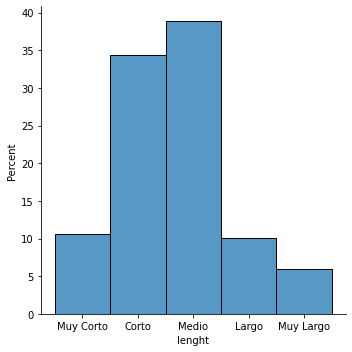

In [16]:
sns.displot(bbe_clean, x = "lenght", stat = "percent");

##### Se categorizan ahora el número de valoraciones recibidas por cada obra, clasificándolas en escala logarítmica. También se procesan los campos porcentuales de las valoraciones.

In [17]:
bbe_clean["numRatings_cat"] = pd.cut(bbe_clean["numRatings"].apply(np.log10), bins = range(2,8), ordered = True, \
    labels = ["10$^2$", "10$^3$", "10$^4$", "10$^5$", "10$^6$"])

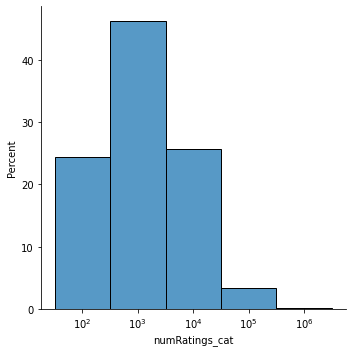

In [18]:
sns.displot(bbe_clean, x = "numRatings_cat", stat = "percent");

In [19]:
bbe_clean["ratingsByStars"] = bbe_clean.apply(lambda x: x["ratingsByStars"][1:-1].replace("'", "").split(","), axis = 1)
bbe_clean[["5_Stars", "4_Stars", "3_Stars", "2_Stars", "1_Stars"]] = bbe_clean.apply(get_ratings, axis = 1, result_type='expand')
bbe_clean = bbe_clean.drop(["ratingsByStars"], axis = 1)

In [20]:
info_plus(bbe_clean)

                   dtype  non_null  unique  non_null_per  unique_per
bookId            object     42692   42692         1.000       1.000
title             object     42692   40621         1.000       0.951
series            object     20992   20485         0.492       0.480
author            object     42692   22038         1.000       0.516
rating           float64     42692     232         1.000       0.005
genres            object     42692   40859         1.000       0.957
pages              int32     42692    1157         1.000       0.027
awards            object     42692    8949         1.000       0.210
numRatings         int64     42692   19108         1.000       0.448
date               int32     42692     216         1.000       0.005
lenght          category     42692       5         1.000       0.000
numRatings_cat  category     42692       5         1.000       0.000
5_Stars          float64     42691     788         1.000       0.018
4_Stars          float64     42691

##### Limpiamos el atributo de los géneros, quedándonos solo con si es de ficción o no y con un género que definimos como principal y asignando una columna propia para cada uno.

In [21]:
bbe_clean = bbe_clean[bbe_clean["genres"] != "[]"]
bbe_clean[["genres", "fiction"]] = bbe_clean[["genres"]].apply(get_genres, axis = 1, result_type='expand')
bbe_clean[["genre"]] = bbe_clean[["genres"]].apply(get_main, axis = 0)
bbe_clean = bbe_clean.drop(["genres"], axis = 1)

In [22]:
f_genres = bbe_clean[bbe_clean["fiction"] == "F"]["genre"].value_counts().head(20).index.to_list()
nf_genres = bbe_clean[bbe_clean["fiction"] == "NF"]["genre"].value_counts().head(20).index.to_list()
bbe_clean["fiction"] = bbe_clean[["fiction", "genre"]].apply(reassign_fiction, args = (f_genres, nf_genres), axis = 1)


In [23]:
info_plus(bbe_clean)

                   dtype  non_null  unique  non_null_per  unique_per
bookId            object     42454   42454         1.000       1.000
title             object     42454   40395         1.000       0.952
series            object     20933   20430         0.493       0.481
author            object     42454   21911         1.000       0.516
rating           float64     42454     224         1.000       0.005
pages              int32     42454    1156         1.000       0.027
awards            object     42454    8941         1.000       0.211
numRatings         int64     42454   19107         1.000       0.450
date               int32     42454     215         1.000       0.005
lenght          category     42454       5         1.000       0.000
numRatings_cat  category     42454       5         1.000       0.000
5_Stars          float64     42454     779         1.000       0.018
4_Stars          float64     42454     463         1.000       0.011
3_Stars          float64     42454

##### Por último, binarizamos el campo de awards y binarizar si pertenece a una saga o no

In [24]:
bbe_clean["awards"] = bbe_clean["awards"].apply(lambda x: False if x == "[]" else True)

In [25]:
bbe_clean["series_bool"] = bbe_clean["series"].apply(lambda x: True if type(x) == str else False)

In [26]:
bbe_clean = bbe_clean[["bookId", "title", "series", "series_bool", "author", "rating", "numRatings", \
    "numRatings_cat", "5_Stars", "4_Stars", "3_Stars", "2_Stars", "1_Stars", "pages", \
    "lenght", "genre", "fiction", "date", "awards"]]
bbe_clean.head()

,bookId,title,series,series_bool,author,rating,numRatings,numRatings_cat,5_Stars,4_Stars,3_Stars,2_Stars,1_Stars,pages,lenght,genre,fiction,date,awards
0,2767052-the-hunger-games,The Hunger Games,The Hunger Games #1,True,Suzanne Collins,4.33,6376780,10$^6$,0.540,0.301,0.117,0.027,0.015,374,Medio,Young adult,F,2008,True
1,2.Harry_Potter_and_the_Order_of_the_Phoenix,Harry Potter and the Order of the Phoenix,Harry Potter #5,True,"J.K. Rowling, Mary GrandPré (Illustrator)",4.50,2507623,10$^6$,0.636,0.254,0.089,0.016,0.006,870,Muy Largo,Fantasy,F,2003,True
2,2657.To_Kill_a_Mockingbird,To Kill a Mockingbird,To Kill a Mockingbird,True,Harper Lee,4.28,4501075,10$^6$,0.525,0.296,0.127,0.033,0.018,324,Medio,Classics,F,1960,True
3,1885.Pride_and_Prejudice,Pride and Prejudice,NaN,False,"Jane Austen, Anna Quindlen (Introduction)",4.26,2998241,10$^6$,0.540,0.272,0.125,0.038,0.026,279,Corto,Classics,F,2000,False
4,41865.Twilight,Twilight,The Twilight Saga #1,True,Stephenie Meyer,3.60,4964519,10$^6$,0.353,0.224,0.203,0.109,0.111,501,Largo,Young adult,F,2005,True


In [27]:
info_plus(bbe_clean)

                   dtype  non_null  unique  non_null_per  unique_per
bookId            object     42454   42454         1.000       1.000
title             object     42454   40395         1.000       0.952
series            object     20933   20430         0.493       0.481
series_bool         bool     42454       2         1.000       0.000
author            object     42454   21911         1.000       0.516
rating           float64     42454     224         1.000       0.005
numRatings         int64     42454   19107         1.000       0.450
numRatings_cat  category     42454       5         1.000       0.000
5_Stars          float64     42454     779         1.000       0.018
4_Stars          float64     42454     463         1.000       0.011
3_Stars          float64     42454     450         1.000       0.011
2_Stars          float64     42454     267         1.000       0.006
1_Stars          float64     42454     211         1.000       0.005
pages              int32     42454

### ANALISIS
##### Relación entre valoraciones y longitud

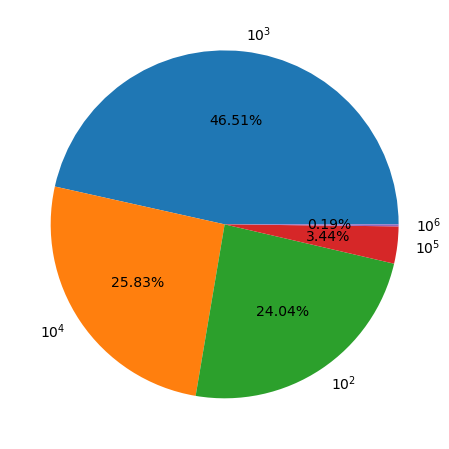

In [28]:
lenght_pie = bbe_clean["numRatings_cat"].value_counts()
fig, ax = plt.subplots(figsize=(15,8))
plt.pie(x=lenght_pie.values, labels=lenght_pie.index, autopct='%1.2f%%', textprops={'fontsize': 14});

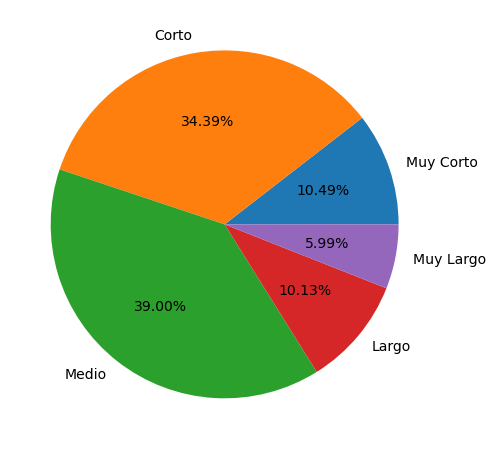

In [29]:
lenght_pie = bbe_clean["lenght"].value_counts().sort_index()
fig, ax = plt.subplots(figsize=(15,8))
plt.pie(x=lenght_pie.values, labels=lenght_pie.index, autopct='%1.2f%%', textprops={'fontsize': 14});

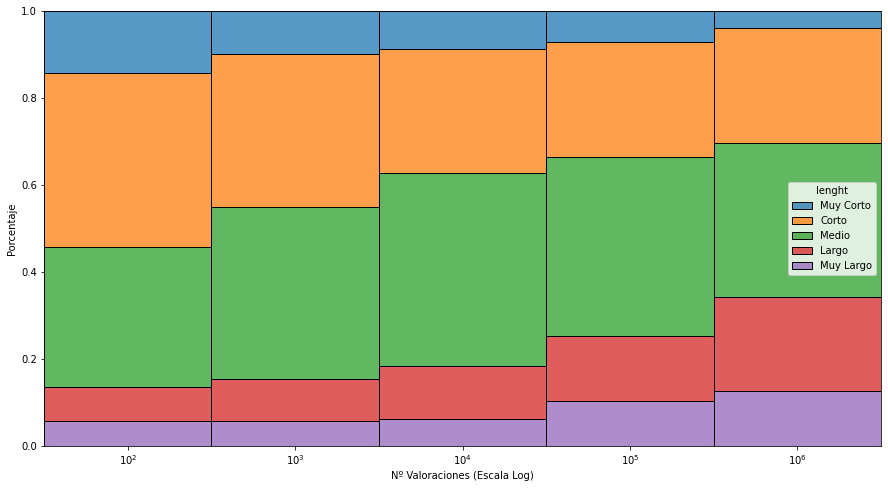

In [30]:
fig, ax = plt.subplots(figsize=(15,8))
ax.set_xlabel('Nº Valoraciones (Escala Log)')
ax.set_ylabel('Porcentaje')
sns.histplot(bbe_clean, x = "numRatings_cat", hue = "lenght", stat = "percent", multiple = "fill");

#### Estudio por géneros
##### Proporción entre obras de ficción y no ficción, su evolución temporal y algunos valores de la estadística descriptiva.

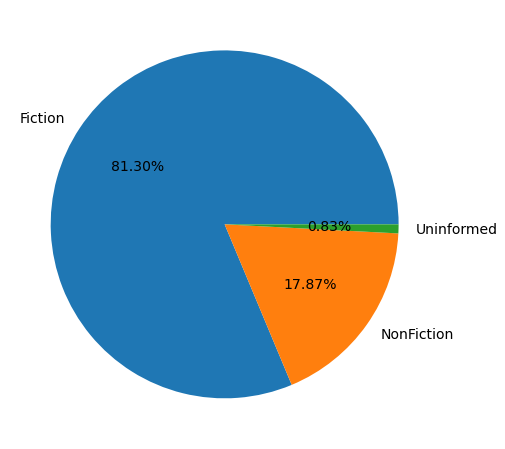

In [31]:
fiction_pie = bbe_clean["fiction"].value_counts()
fig, ax = plt.subplots(figsize=(15,8))
plt.pie(fiction_pie.values, labels=["Fiction", "NonFiction", "Uninformed"], autopct='%1.2f%%', textprops={'fontsize': 14});

<AxesSubplot:xlabel='Año', ylabel='Nº Publicaciones'>

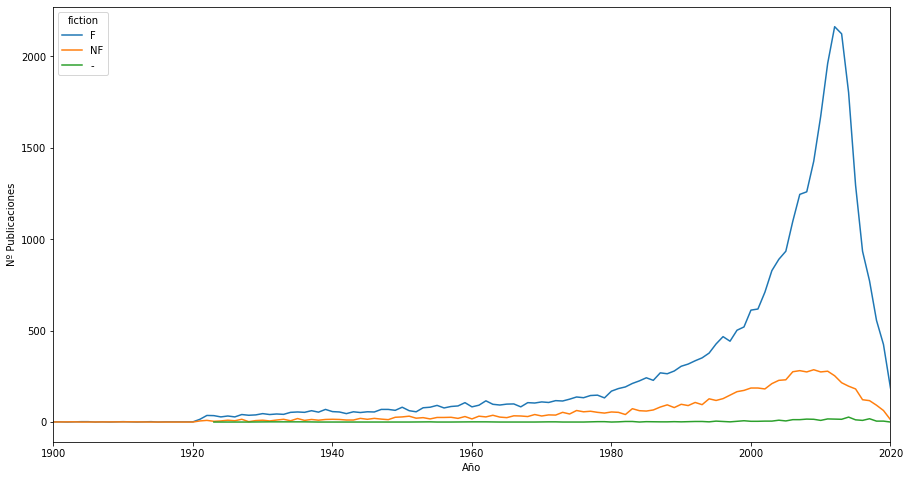

In [32]:
bbe_date_fic = bbe_clean.groupby(["date", "fiction"]).count()

fig, ax = plt.subplots(figsize=(15,8))
ax.set_xlabel('Año')
ax.set_xlim(1900, 2020)
ax.set_ylabel('Nº Publicaciones')
sns.lineplot(data = bbe_date_fic, x = "date", y = "bookId", hue = "fiction", ax=ax, hue_order=["F", "NF", "-"])


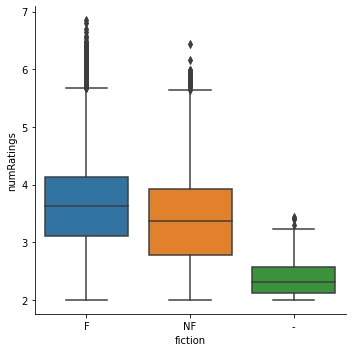

In [33]:
data = bbe_clean.copy()
data["numRatings"] = data["numRatings"].apply(np.log10)
sns.catplot(x="fiction", y="numRatings", kind="box", data=data);

In [34]:
fiction = bbe_clean[(bbe_clean["fiction"] == "F")]
fiction = fiction.drop(["fiction"], axis = 1)
fiction[["numRatings", "rating", "pages"]].describe()

,numRatings,rating,pages
count,3.451500e+04,34515.000000,34515.000000
mean,2.377355e+04,3.976158,333.193742
std,1.243254e+05,0.279584,168.734941
min,1.010000e+02,1.990000,2.000000
25%,1.276500e+03,3.800000,230.000000
50%,4.324000e+03,3.990000,320.000000
75%,1.369500e+04,4.170000,400.000000
max,7.048471e+06,4.920000,1492.000000


In [35]:
nonfiction = bbe_clean[(bbe_clean["fiction"] == "NF")]
nonfiction = nonfiction.drop(["fiction"], axis = 1)
nonfiction[["numRatings", "rating", "pages"]].describe()

,numRatings,rating,pages
count,7.587000e+03,7587.000000,7587.000000
mean,1.449563e+04,4.064144,330.283643
std,6.145175e+04,0.257087,184.716288
min,1.010000e+02,2.390000,2.000000
25%,6.125000e+02,3.910000,223.000000
50%,2.351000e+03,4.090000,291.000000
75%,8.496500e+03,4.240000,388.000000
max,2.741134e+06,4.930000,1430.000000


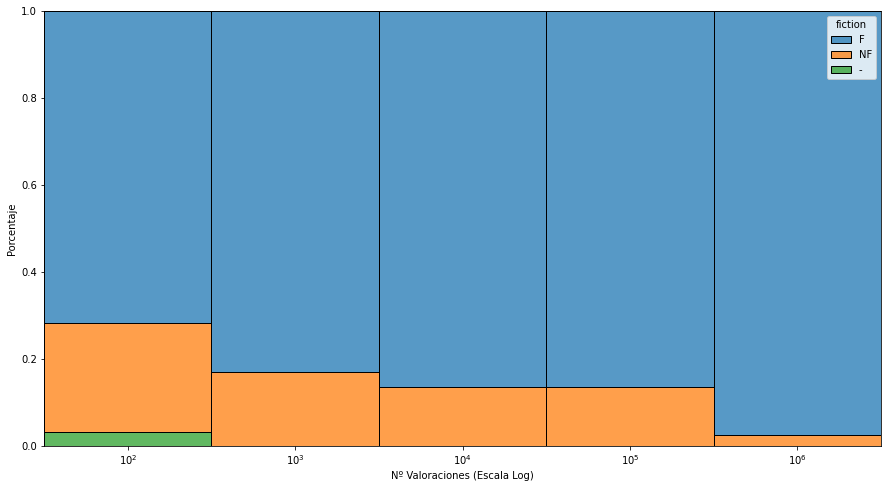

In [36]:
fig, ax = plt.subplots(figsize=(15,8))
ax.set_xlabel('Nº Valoraciones (Escala Log)')
ax.set_ylabel('Porcentaje')
sns.histplot(bbe_clean, x = "numRatings_cat", hue = "fiction", stat = "percent", multiple = "fill");

##### Géneros más publicados en no ficción y en ficción.

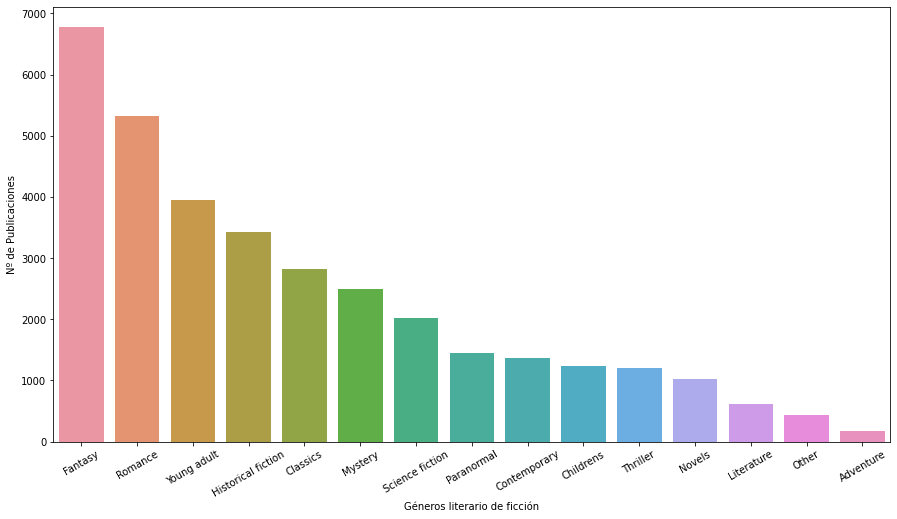

In [37]:
f_genres_pub = fiction["genre"].value_counts().head(15)
f_genres_pub_list = f_genres_pub.index.to_list()

fig, ax = plt.subplots(figsize=(15,8))
ax.set_xlabel('Géneros literario de ficción')
ax.set_ylabel('Nº de Publicaciones')
sns.barplot(x=f_genres_pub.index, y=f_genres_pub.values)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30);

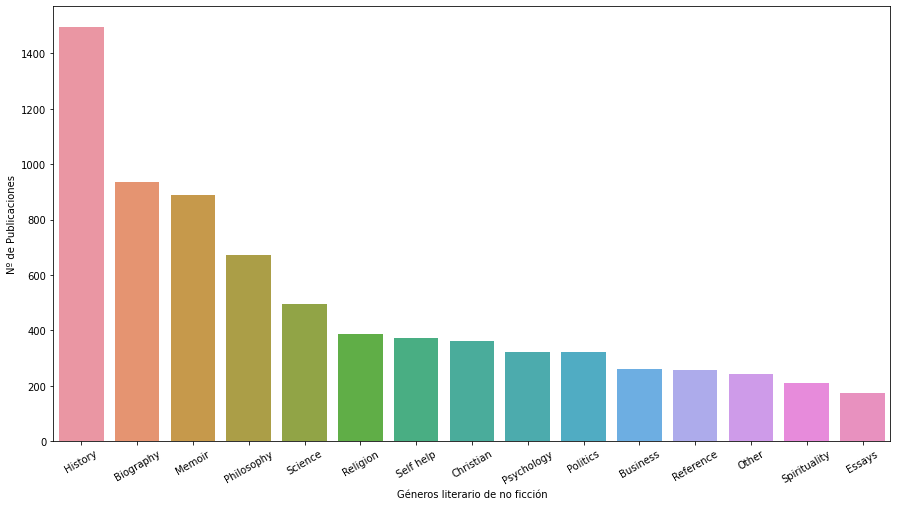

In [38]:
nf_genres_pub = nonfiction["genre"].value_counts().head(15)

fig, ax = plt.subplots(figsize=(15,8))
ax.set_xlabel('Géneros literario de no ficción')
ax.set_ylabel('Nº de Publicaciones')
sns.barplot(x=nf_genres_pub.index, y=nf_genres_pub.values)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30);


##### Valoraciones medias por géneros de ficción

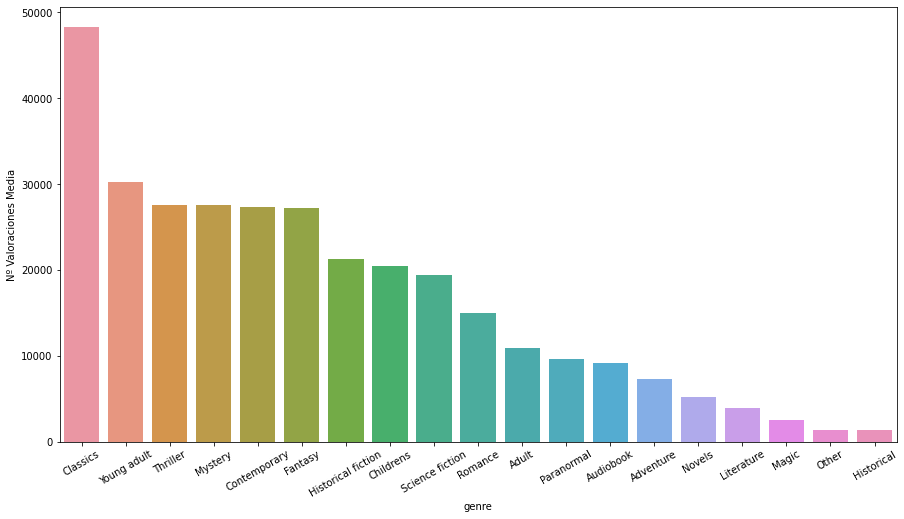

In [39]:
numRat_avg = fiction.groupby("genre")["numRatings"].mean().sort_values(ascending=False)
fiction_genres = numRat_avg.index.to_list()
fig, ax = plt.subplots(figsize=(15,8))
ax.set_xlabel('Género')
ax.set_ylabel('Nº Valoraciones Media')
sns.barplot(x=numRat_avg.index, y=numRat_avg.values);
ax.set_xticklabels(ax.get_xticklabels(), rotation=30);

In [40]:
#set(fiction_genres[:10]).intersection(f_genres_pub_list[:10])

##### Evolución temporal de los géneros más valorados de media

(1950.0, 2020.0)

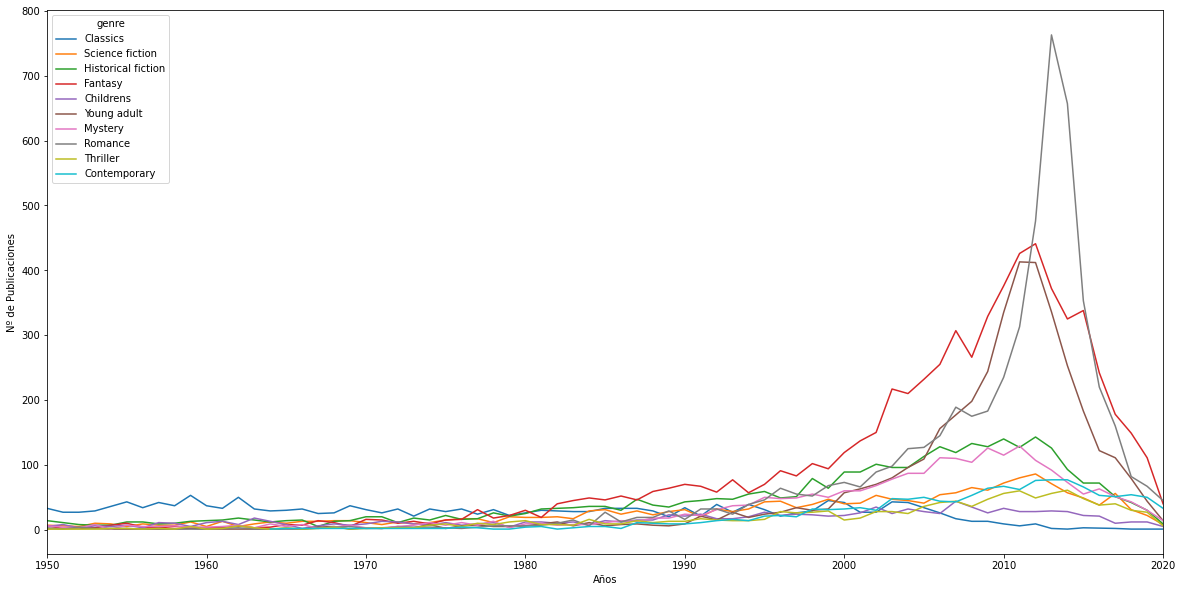

In [41]:
fiction_date_fic = fiction[fiction["genre"].isin(fiction_genres[:10])].groupby(["date", "genre"]).count()

fig, ax = plt.subplots(figsize=(20,10))
ax.set_xlabel('Años')
ax.set_ylabel('Nº de Publicaciones')
sns.lineplot(data = fiction_date_fic, x = "date", y = "bookId", hue = "genre", ax=ax)
ax.set_xlim(1950, 2020)

##### Distribución de los géneros en las categorías de numRatings (con y sin Clásicos)

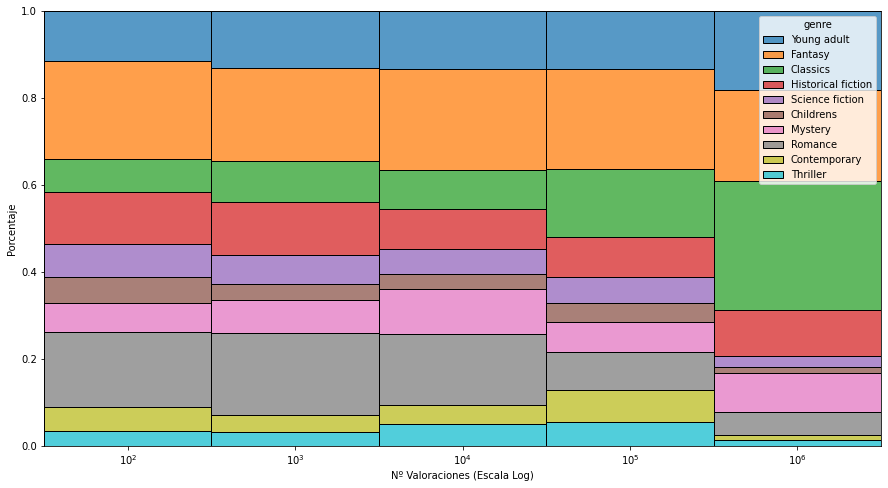

In [42]:
fig, ax = plt.subplots(figsize=(15,8))
ax.set_xlabel('Nº Valoraciones (Escala Log)')
ax.set_ylabel('Porcentaje')
sns.histplot(fiction[fiction["genre"].isin(fiction_genres[:10])], x = "numRatings_cat", hue = "genre", stat = "percent", multiple = "fill");

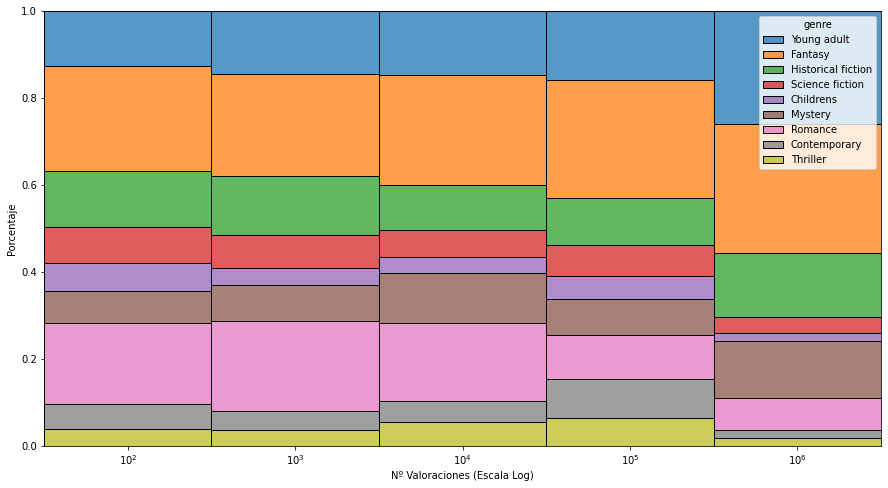

In [43]:
fig, ax = plt.subplots(figsize=(15,8))
ax.set_xlabel('Nº Valoraciones (Escala Log)')
ax.set_ylabel('Porcentaje')
sns.histplot(fiction[(fiction["genre"].isin(fiction_genres[:10])) & (fiction["genre"] != "Classics")], x = "numRatings_cat", hue = "genre", stat = "percent", multiple = "fill");

##### Distribución por género, categoría de numRatings, número de páginas y si pertenece o no a una saga. Las figuras dentro de una misma gráfica no están a escala entre ellas.

In [48]:
possible_genres = ["Young adult", "Fantasy", "Historical fiction", "Mystery", "Romance", "Contemporary", "Childrens", "Science fiction"]
selected_fiction = fiction[(fiction["genre"].isin(possible_genres)) & (fiction["numRatings"] > 10000)]

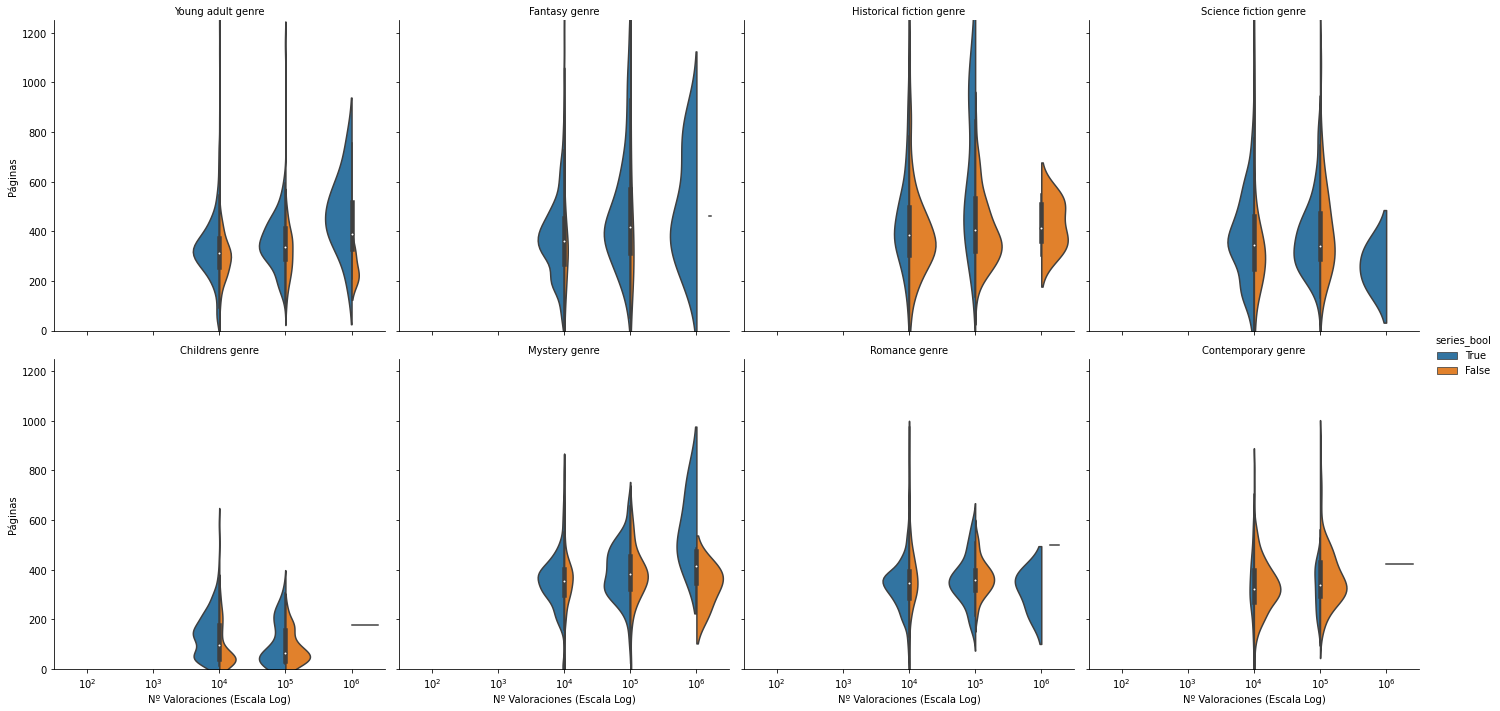

In [50]:
violin = sns.catplot(data=selected_fiction, x="numRatings_cat", y="pages", hue="series_bool", col="genre", kind="violin", s=2, hue_order=[True, False], split = True, scale="count", col_wrap=4)
violin.set_axis_labels("Nº Valoraciones (Escala Log)", "Páginas").set_titles("{col_name} {col_var}").set(ylim=(0, 1250));

##### Relación entre número de publicaciones y número de valoraciones medias por género. Los géneros con muchas publicaciones acaban teniendo muchos que pasan desapercibidos.

In [51]:
numPub = pd.Series(fiction[fiction["genre"].isin(fiction_genres[:10]) & (fiction["genre"] != "Classics")].value_counts("genre").sort_index())
avg_Rat = pd.Series(fiction[fiction["genre"].isin(fiction_genres[:10]) & (fiction["genre"] != "Classics")].groupby("genre")["numRatings"].mean().sort_index())
df = pd.DataFrame({"NumPublicaciones": numPub, "ValoracionMedia": avg_Rat})
df["Ratio"] = df["ValoracionMedia"] / df["NumPublicaciones"]
df = df.sort_values("Ratio", ascending = False)

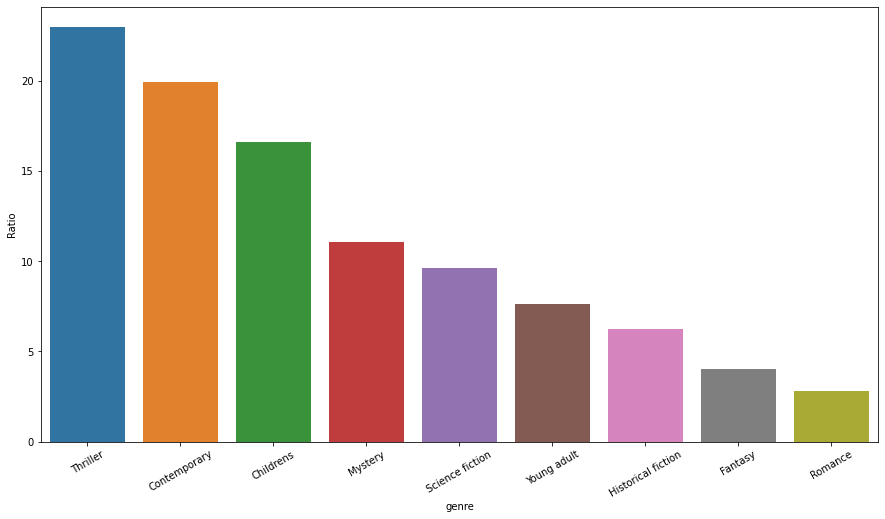

In [54]:
fig, ax = plt.subplots(figsize=(15,8))
ax.set_xlabel('Género')
sns.barplot(x=df.index, y=df["Ratio"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=30);

##### Proporción de libros galardonados o nominados según categoría de numRatings.

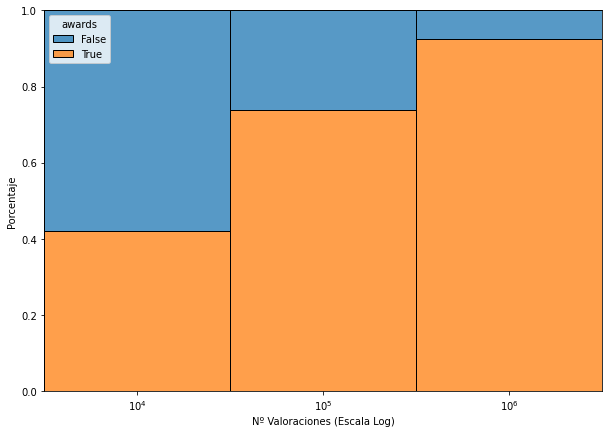

In [57]:
fig, ax = plt.subplots(figsize=(10,7))
ax.set_xlabel('Nº Valoraciones (Escala Log)')
ax.set_ylabel('Porcentaje')
sns.histplot(selected_fiction, x="numRatings_cat", hue="awards", stat="percent", multiple="fill");